# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

## Data

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc

Install library for processing the labeling
```bash
pip install xmltodict
```

In [2]:
import xmltodict, json

В этом задании потребуется обучить детектор фруктов на изображении. Данные находятся в архиве `data.zip`. Данные уже поделены на train и test.

Датасет для трех классов.

In [12]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None, classification=True):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                if classification:
                    labels.append(class2tag[obj["name"]])
                else:
                    labels.append(1)
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

<br>  
<br>  
Функции для вычисления mAP.

In [13]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

{'boxes': tensor([[174.,  20., 364., 199.]]), 'labels': tensor([1])}


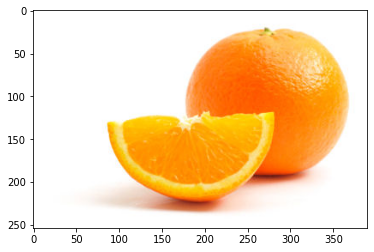

In [14]:
fd = FruitDataset("test/", classification=False)
for el in fd:
    plt.imshow(el[0])
    print(el[1])
    break

In [44]:
torch.tensor(fd[0][0]).shape

torch.Size([254, 390, 3])

In [24]:
batch_size=1
test_dataloader = DataLoader(fd, batch_size=batch_size)
for batch, (X, y) in enumerate(test_dataloader):
    print(batch)
    #print(X)
    print(y)
    print("Shape of X [N, C, H, W]: ", X[0].shape)
    print("Shape of y: ", y['boxes'].shape, y['boxes'].dtype)
    break

0
{'boxes': tensor([[[174.,  20., 364., 199.]]]), 'labels': tensor([[1]])}
Shape of X [N, C, H, W]:  torch.Size([254, 390, 3])
Shape of y:  torch.Size([1, 1, 4]) torch.float32


### Задание 1.  
  
Примените обученные детекторы из [torchvision.models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете. 

In [25]:
import torchvision.models as models

In [31]:
retina = models.detection.retinanet_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /home/ironic/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
18.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

46.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

74.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set 

In [32]:
rcnn = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /home/ironic/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
31.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

80.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [34]:
#evaluate(retina, test_dataloader, device)

In [50]:
retina.eval()
retina(torch.tensor(fd[0][0]).reshape([1,3,254,390]).float())

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64)}]

In [48]:
rcnn.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [49]:
rcnn(torch.tensor(fd[0][0]).reshape([1,3,254,390]).float())

[{'boxes': tensor([[  0.0000,   0.0000, 390.0000, 148.5740],
          [326.1980,   0.0000, 390.0000, 140.1998]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([1.0000, 0.9962], grad_fn=<IndexBackward0>)}]

In [62]:
ssd = models.detection.ssd300_vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /home/ironic/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
17.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

45.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

73.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


In [65]:
ssd.eval()
ssd(torch.tensor(fd[0][0]).reshape([1,3,254,390]).float())

[{'boxes': tensor([[254.3917, 140.4735, 259.5894, 143.0042],
          [264.9964, 140.3934, 269.8755, 142.9333],
          [254.7827, 134.3811, 259.8310, 136.5091],
          [265.7581, 134.2333, 270.5089, 136.2777],
          [183.0021, 195.3605, 187.6199, 197.2271],
          [172.9177, 195.5568, 177.4763, 197.3273],
          [193.4450, 195.2056, 198.2732, 197.1435],
          [255.3161, 127.5680, 260.1579, 129.5022],
          [ 68.4202, 100.8565,  73.1217, 102.5572],
          [244.6400, 134.3537, 249.9356, 136.4585],
          [ 58.4720, 100.9817,  62.8889, 102.6106]], grad_fn=<StackBackward0>),
  'scores': tensor([0.0108, 0.0107, 0.0107, 0.0105, 0.0105, 0.0103, 0.0102, 0.0101, 0.0101,
          0.0100, 0.0100], grad_fn=<IndexBackward0>),
  'labels': tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])}]

### Задание 2.  
  
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.  
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество. 

### Задание 3.  
  
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

### Задание 4.  
  
Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета и каких-нибудь картинок из __интернета__ (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

### Задание 5.  
  
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.   
**NB:** Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса. 

<br>  
<br>  
  
## Часть 2.  
  
*Вес в общей оценке - 0.4*  
  
Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

<br>  
<br>  
  
## Часть 3.  
  
*Вес в общей оценке - 0.2*  
  
Обучите модель для object detection для трех классов на __обучающем__ датасете и добейтесь PR AUC не менее __0.91__ на  __тестовом__.  
Баллы за задание вычисляются по формуле: __min(2, 2 * Ваш auc / 0.91)__.

<br>  
<br>  
  
## Бонусные задания.  
  
1. При обучении используйте аугментации (в первую очередь пространственные) из [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) или [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html).  
2. Возьмите одну из [детекционных архитектур](https://paperswithcode.com/sota/object-detection-on-coco) (желательно, не старее 2020 года), у которой выложены тренировочный код и чекпоинты на гитхабе, обучите и провалидируйте ее на данных этой лабораторной. 